In [32]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
from scipy import linalg
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


**Pull in Dataset**

In [33]:
# os.makedirs("celeba_gan", exist_ok=True)

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)

# with zipfile.ZipFile(output, "r") as zipobj:
#     zipobj.extractall("celeba_gan")

**Prepare and Visualize data**

Dataset size: 202599


Dataset size: 202599


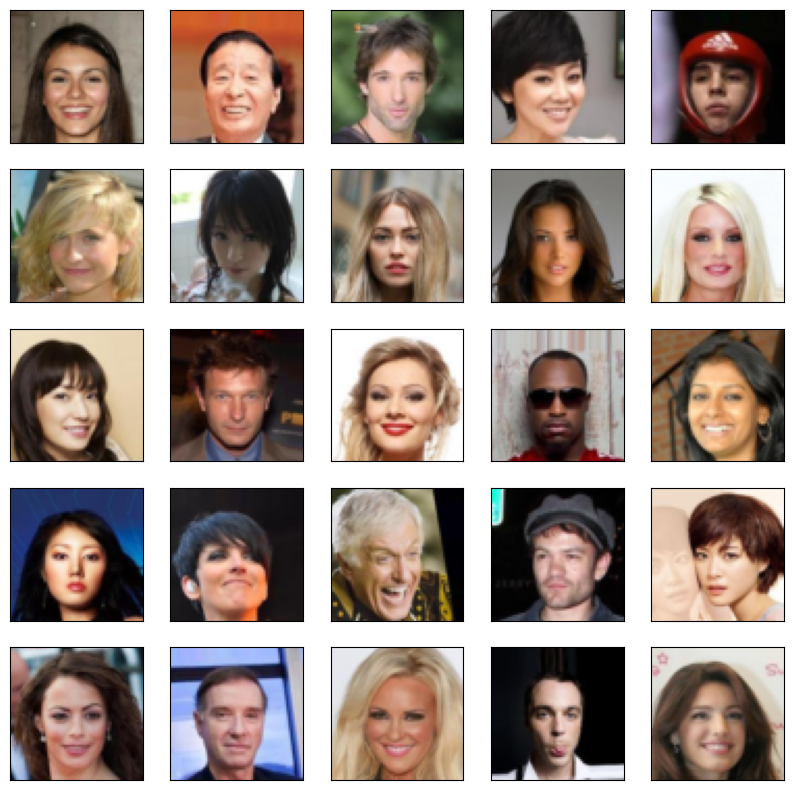

In [34]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])

from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="celeba_gan", transform=transform)

dataloader = DataLoader(
    dataset, 
    batch_size=128,  
    shuffle=True, 
    num_workers=4,   
    pin_memory=True, 
    persistent_workers=True 
)

print(f"Dataset size: {len(dataset)}")

imgs, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = (imgs[i].permute(1, 2, 0).numpy() + 1) / 2.0
    plt.imshow(img)
plt.show()

**Load in models**

In [ ]:
latent_dim = 128

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim -> 8x8x256
            nn.Linear(latent_dim, 8 * 8 * 256),
            nn.Unflatten(1, (256, 8, 8)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 32x32 -> 64x64 (Output Layer)
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 64x64 → 32x32
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32 → 16x16
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 → 8x8
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 → 4x4
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator parameters (M):", sum(p.numel() for p in generator.parameters())/1e6)
print("Discriminator parameters (M):", sum(p.numel() for p in discriminator.parameters())/1e6)

Generator parameters (M): 3.822403
Discriminator parameters (M): 2.766529


**Set up optimizers and Loss function**

In [ ]:
g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999),
    fused=True
)

criterion = torch.nn.BCEWithLogitsLoss()

**Save generates images to review**

In [37]:
@torch.no_grad()
def save_images(model, epoch, latent_dim, n=4):
    model.eval()
    noise = torch.randn(n * n, latent_dim, device=device)
    generated_images = model(noise)
    generated_images = (generated_images + 1) / 2.0  
    
    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = generated_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.savefig("generated_image_epoch_%d.png" % epoch)
    plt.close()
    model.train()

**Training Loop**

In [38]:
def train_dcgan(epochs, dataloader, latent_dim):
    generator.train()
    discriminator.train()
    
    scaler = torch.cuda.amp()
    
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_images, _ in pbar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device, non_blocking=True) 
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            d_optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp():
                real_output = discriminator(real_images)
                d_loss_real = criterion(real_output, real_labels)
                
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images.detach())
                d_loss_fake = criterion(fake_output, fake_labels)
                
                d_loss = d_loss_real + d_loss_fake
            
            scaler.scale(d_loss).backward()
            scaler.step(d_optimizer)
            scaler.update()
            
            g_optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp():
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images)
                g_loss = criterion(fake_output, real_labels)
            
            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            scaler.update()
            
            pbar.set_postfix({"D_loss": d_loss.item(), "G_loss": g_loss.item()})
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_images(generator, epoch + 1, latent_dim)
        
        print(f"Epoch {epoch+1}/{epochs} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

**Load in pretrained models**

In [ ]:
generator.load_state_dict(torch.load('model/generator_final.pth', map_location=device))
discriminator.load_state_dict(torch.load('model/discriminator_final.pth', map_location=device))

generator.eval()
discriminator.eval()

print("✓ Models loaded successfully!")
print("Generator and Discriminator are ready for evaluation.")

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "main.11.weight", "main.11.bias", "main.11.running_mean", "main.11.running_var", "main.13.weight", "main.13.bias". 
	size mismatch for main.10.weight: copying a param with shape torch.Size([128, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for main.10.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([64]).

**Evaluate models**

In [ ]:
def evaluate_gan(generator, discriminator, dataloader, criterion, latent_dim, device):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        real_images, _ = next(iter(dataloader))
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_output = discriminator(real_images)
        real_labels = torch.ones_like(real_output)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        fake_output_d = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_output_d)
        d_loss_fake = criterion(fake_output_d, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        fake_output_g = discriminator(fake_images)
        real_labels = torch.ones_like(fake_output_g)
        g_loss = criterion(fake_output_g, real_labels)

    generator.train()
    discriminator.train()

    return d_loss.item(), g_loss.item()


**Calculate FID**

In [ ]:
class InceptionFID(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = inception_v3(weights="IMAGENET1K_V1", transform_input=False)
        self.model.fc = torch.nn.Identity()   # remove final classifier
        self.model.eval()

    @torch.no_grad()
    def forward(self, x):
        x = (x + 1) / 2
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

        return self.model(x)


def calculate_fid(real_images, fake_images, device="cuda"):
    real_images = real_images.to(device)
    fake_images = fake_images.to(device)

    inception = InceptionFID().to(device)

    with torch.no_grad():
        act_real = inception(real_images).cpu().numpy()
        act_fake = inception(fake_images).cpu().numpy()

    mu_r, mu_f = act_real.mean(axis=0), act_fake.mean(axis=0)
    sigma_r, sigma_f = np.cov(act_real, rowvar=False), np.cov(act_fake, rowvar=False)

    covmean, _ = linalg.sqrtm(sigma_r @ sigma_f, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum((mu_r - mu_f)**2) + np.trace(
        sigma_r + sigma_f - 2 * covmean
    )
    return float(fid)

In [ ]:
def compute_fid_score(generator, dataloader, latent_dim, num_samples=1000):
    generator.eval()

    real_imgs = []
    fake_imgs = []

    # Collect real images
    for imgs, _ in dataloader:
        real_imgs.append(imgs)
        if len(torch.cat(real_imgs)) >= num_samples:
            break

    real_imgs = torch.cat(real_imgs)[:num_samples]

    # Generate fake images
    noise = torch.randn(num_samples, latent_dim, device=device)
    with torch.no_grad():
        fake_imgs = generator(noise).cpu()

    # Compute FID
    fid = calculate_fid(real_imgs, fake_imgs, device=device)
    return fid

**Print out results**

In [ ]:
d, g = evaluate_gan(generator, discriminator, dataloader, criterion, latent_dim, device)
print(f"D Loss: {d:.4f}, G Loss: {g:.4f}")

fid_score = compute_fid_score(generator, dataloader, latent_dim)
print("FID:", fid_score)


RuntimeError: all elements of input should be between 0 and 1